## Imports

In [109]:
# Add parent directory to path for local imports
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as T
import bcolz
import time
import random
from textwrap import wrap
from torch.utils.data import Dataset, DataLoader, sampler
%matplotlib inline

In [74]:
use_gpu = torch.cuda.is_available()
print('Using gpu: %s ' % use_gpu)

def gpu(x,use_gpu=use_gpu):
    if use_gpu:
        return x.cuda()
    else:
        return x

Using gpu: True 


## Data processing

In [75]:
transform = T.Compose([
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class ImageFolderWithPaths(dset.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """
    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

train_dataset = ImageFolderWithPaths('../Dataset/train', transform=transform)
val_dataset = ImageFolderWithPaths('../Dataset/val', transform=transform)
test_dataset = ImageFolderWithPaths('../Dataset/test', transform=transform)

In [101]:
classes = train_dataset.classes
print(len(classes))
print(classes)

172
['1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '16', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '17', '170', '171', '172', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', 

In [77]:
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)
print("Number of training examples {}, validation examples {}, testing examples {}".format(train_size, val_size, test_size))

Number of training examples 66071, validation examples 11016, testing examples 33154


In [78]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=6)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=6)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=6)

In [79]:
FOOD_LIST_PATH = '../VireoFood172/SplitAndIngreLabel/FoodList.txt'
food_names = [] # List of length 172 where index is the food label, and value is the food name.
with open(FOOD_LIST_PATH) as fp:
    food_names = fp.read().splitlines()

classes = train_dataset.classes

In [99]:
print(food_names[132])

Steamed Bun Stuffed


## Saliency Maps

In [80]:
# Load the model.
PATH = "../saved_models/food/res18/res18.dat"
loaded_model = torch.load(PATH)
loaded_model = gpu(loaded_model)
model = loaded_model
history = torch.load('../saved_models/food/res18/res18-history.pt')
LOSS, ACC, LOSS_V, ACC_V = (history['loss'], history['acc'], history['loss_v'], history['acc_v'])

for param in model.parameters():
    param.requires_grad = False

In [103]:
def preprocess(image, size=224):
    transform = T.Compose([
        T.CenterCrop(size),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform(image)

def deprocess(image):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
        T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        T.ToPILImage(),
    ])
    return transform(image)

def show_img(PIL_IMG):
    plt.imshow(np.asarray(PIL_IMG))

In [82]:
# Build a map from class label (an int in the range [0, 171]) to the list of paths to images of that class.
test_paths = dict()
for i in range(len(food_names)):
    test_paths[i] = []

num_batches = 0
for data in test_dataloader:
    images, labels, paths = data
    for i in range(images.shape[0]):
        path = paths[i]
        label = labels[i].item()
        test_paths[label].append(path)

In [153]:
# Get a random list of N images to compute saliency maps for.

N = 10
saliency_list = []
images = []
labels = []
paths = []
for i in range(N):
    label = random.randint(0, len(classes) - 1)
    image_index = random.randint(0, len(test_paths[label]))
    path = test_paths[label][image_index]
    image = Image.open(path)
    images.append(preprocess(image))
    labels.append(label)
    paths.append(path)
images = torch.stack(images, axis=0)
print(labels)

[93, 163, 93, 102, 43, 89, 83, 58, 154, 50]


In [154]:
def compute_saliency_maps(images, labels, model):
    model.eval()
    saliency_list = []
    num_images = images.shape[0]
    for i in range(num_images):
        X = images[[i], :, :, :]
        y = labels[i]
        X = gpu(X)
        X.requires_grad_()
        scores = model(X)
        score_max_index = scores.argmax()
        score_max = scores[0, score_max_index]
        score_max.backward()
        saliency, _ = torch.max(torch.abs(X.grad.data), dim=1)
        saliency_list.append(saliency.cpu())
    return saliency_list

saliency_list = compute_saliency_maps(images, labels, model)

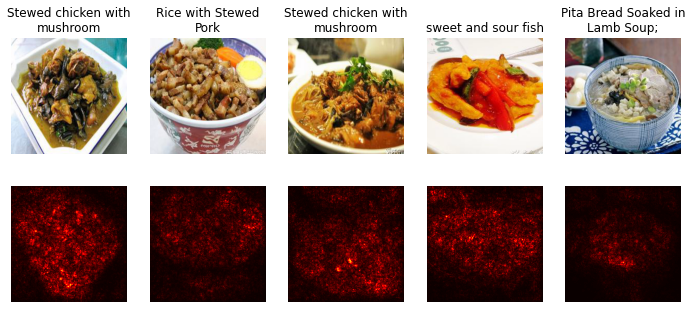

In [157]:
N = 5
line_length = 20
for i in range(N):
    plt.subplot(2, N, i + 1)
    show_img(deprocess(images[[i],:,:,:]))
    plt.axis('off')
    plt.title("\n".join(wrap(food_names[int(classes[labels[i]]) - 1], line_length)))
    plt.subplot(2, N, N + i + 1)
    plt.imshow(saliency_list[i][0], cmap=plt.cm.hot)
    plt.axis('off')
    plt.gcf().set_size_inches(12, 5)
plt.show()

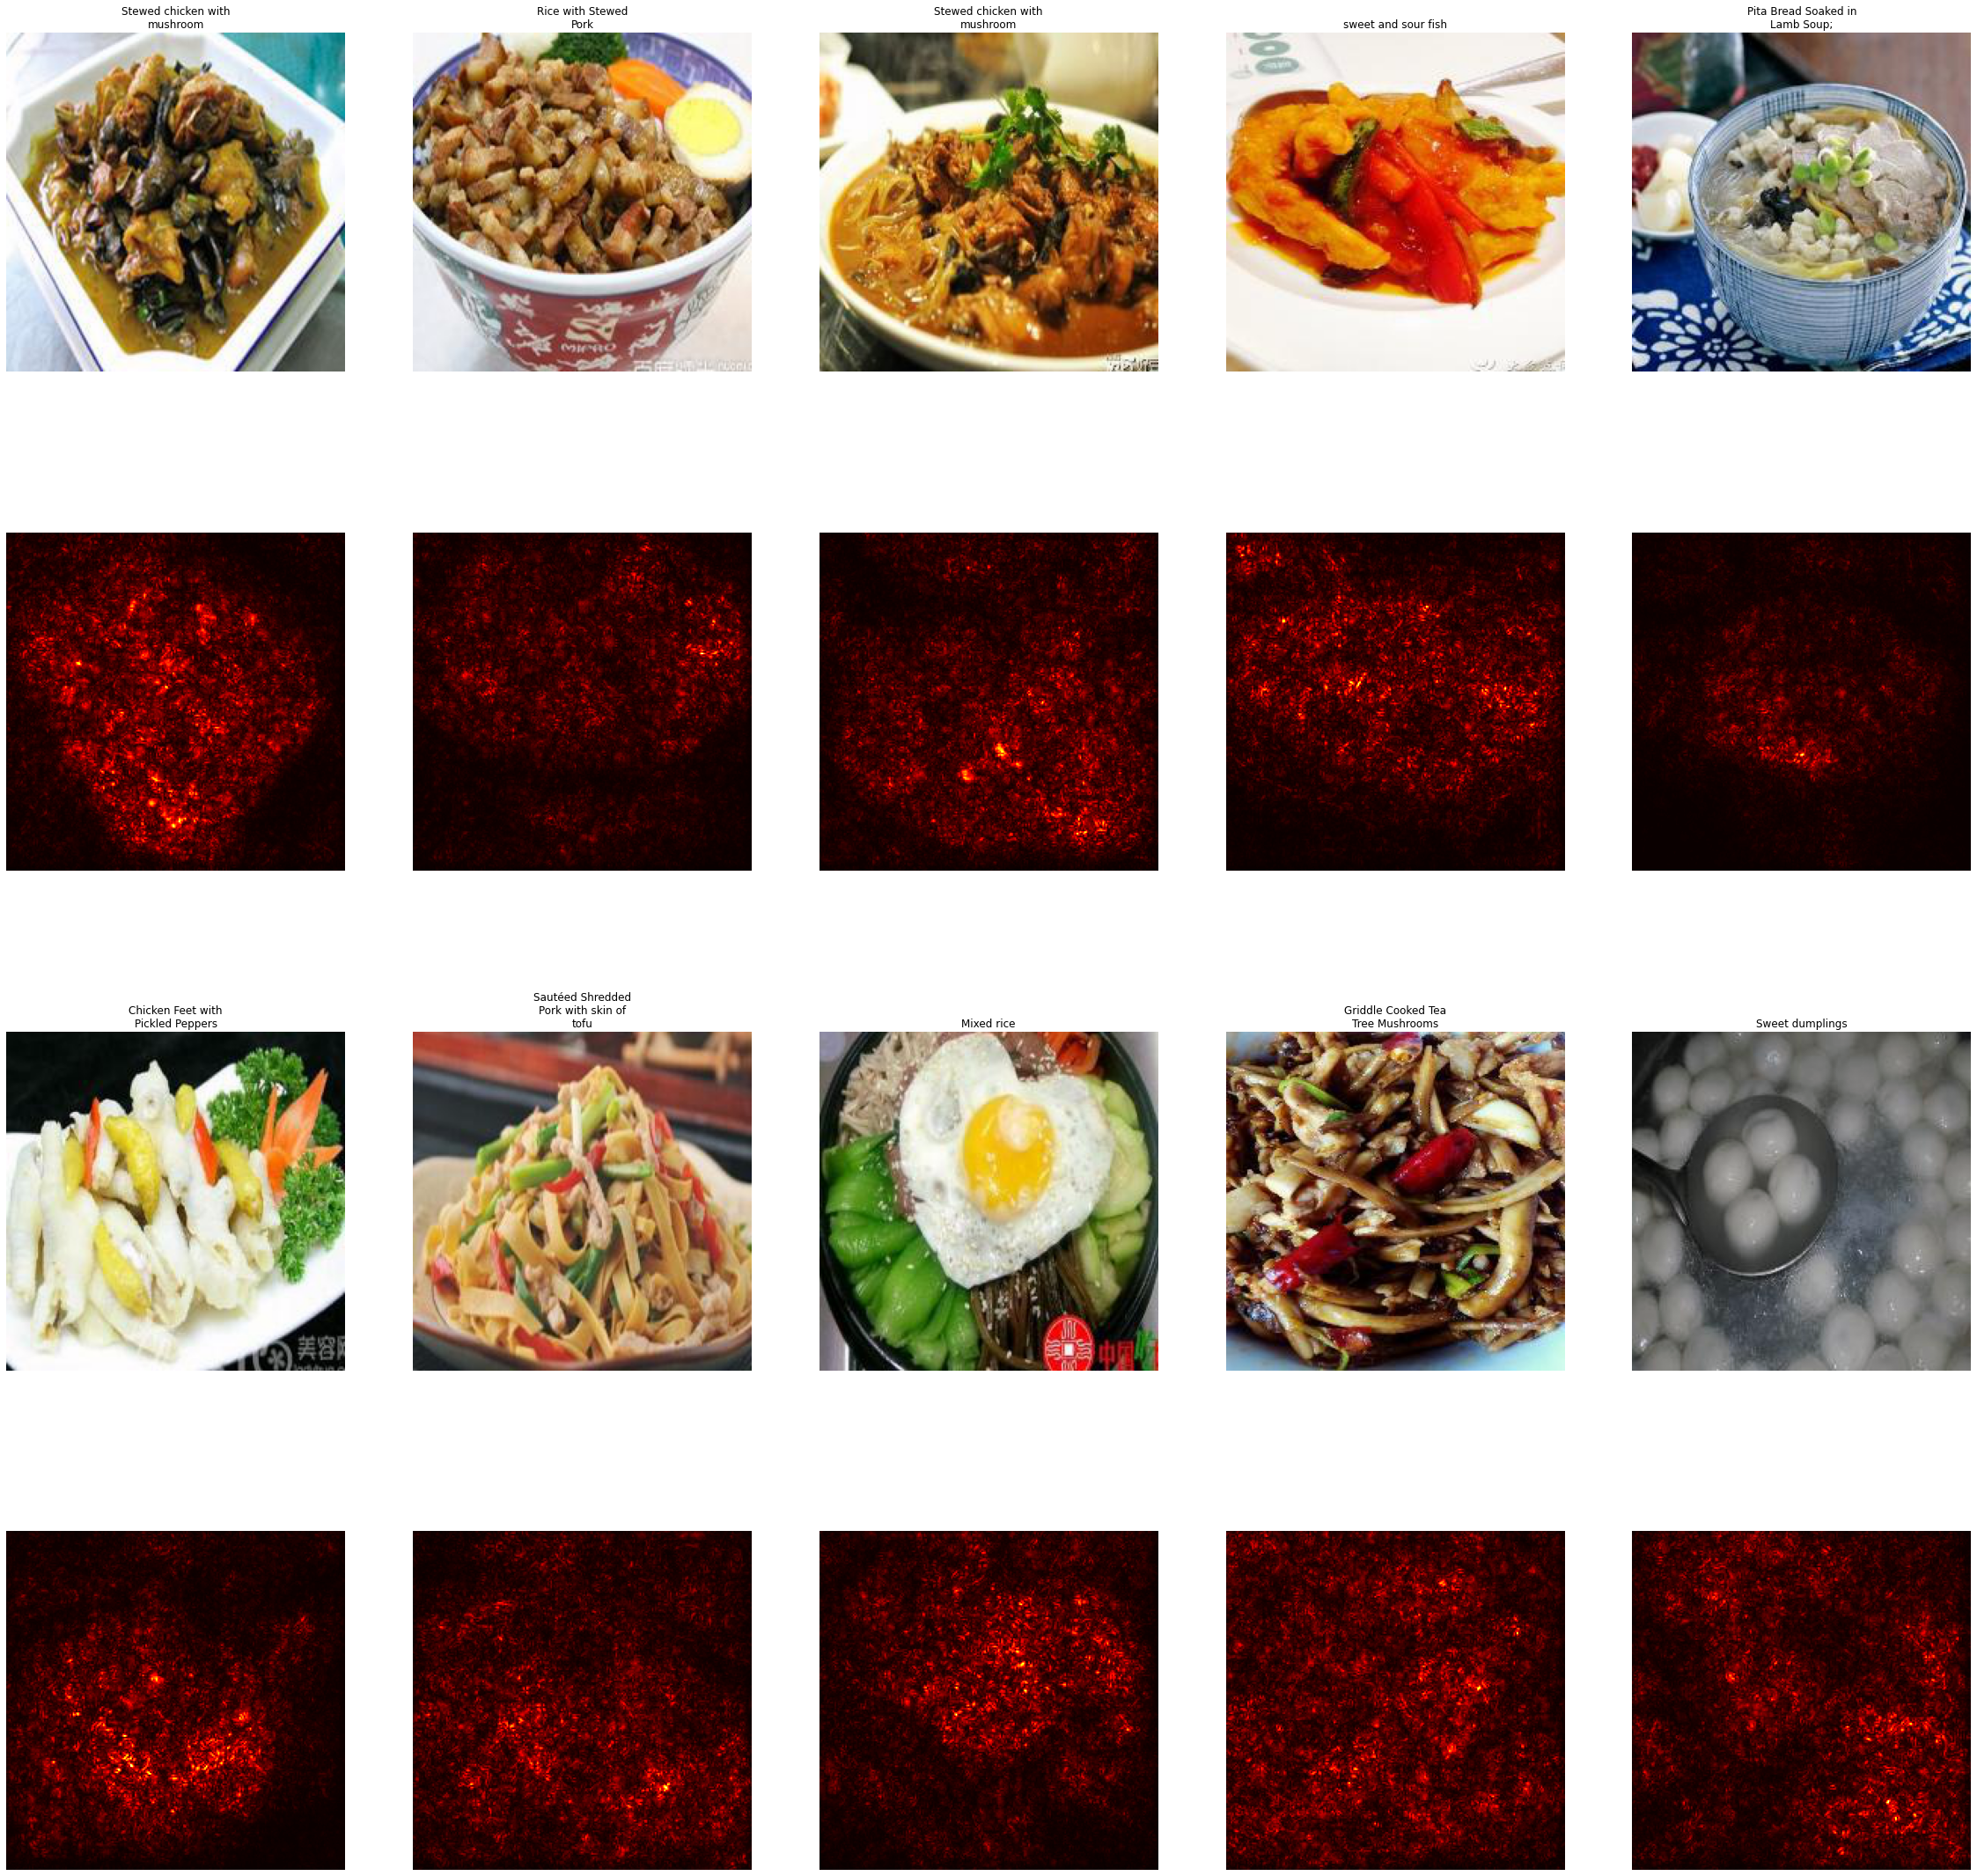

In [158]:
N = 10
line_length = 20
cols = 5
rows = 2 * (N // cols)
for i in range(N):
    plt.subplot(rows, cols, cols*(i//cols) + i + 1)
    show_img(deprocess(images[[i],:,:,:]))
    plt.axis('off')
    plt.title("\n".join(wrap(food_names[int(classes[labels[i]]) - 1], line_length)))
    plt.subplot(rows, cols, cols*(i//cols) + cols + i + 1)
    plt.imshow(saliency_list[i][0], cmap=plt.cm.hot)
    plt.axis('off')
    plt.gcf().set_size_inches(40, 40)
plt.show()